<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis 
* Iterators

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta 

import os
import re 

from functools import reduce
from collections import defaultdict

import prophet as pr

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'online_retail.xlsx',
 '1_order_payments_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_orders_dataset.csv',
 'online_retail_II.xlsx',
 'ecommerce-data.csv',
 'groceries.csv',
 'match_result_test.csv',
 'sales_data_with_stores.csv',
 'bz_data_analyis.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'mall_customers.csv',
 'sales_vs_discount.csv',
 '1_customers_dataset.csv',
 'sample-sales-data.csv',
 'mock_sales_data.csv',
 'sales.csv',
 'test.csv',
 'scanner_data.csv',
 'sample_data']

In [7]:
df = pd.read_csv('1_orders_dataset.csv').reindex(['customer_id', 'order_status', 'order_purchase_timestamp'], axis = 1)
df.columns = ['id', 'status', 'log_date']
df['log_date'] = pd.to_datetime(df['log_date'], infer_datetime_format=True)
df.head()

,id,status,log_date
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [8]:
df['status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: status, dtype: int64

In [9]:
df = df[df['status'] == 'delivered']
df.head()

,id,status,log_date
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39


In [13]:
list_id = dict(zip(df['id'].unique(), range(len(df['id'].unique()))))

In [14]:
df['mem_id'] = df['id'].apply(lambda x : list_id.get(x,x))
df.head()

,id,status,log_date,mem_id
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,0
1,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,1
2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2
3,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,3
4,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,4


In [16]:
df['date'] = df.log_date.to_numpy().astype('datetime64[D]')
df['month'] = df.log_date.to_numpy().astype('datetime64[M]')
df.head()

,id,status,log_date,mem_id,date,month
0,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,0,2017-10-02,2017-10-01
1,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,1,2018-07-24,2018-07-01
2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2,2018-08-08,2018-08-01
3,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,3,2017-11-18,2017-11-01
4,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,4,2018-02-13,2018-02-01


In [42]:
info_f = df.groupby(['mem_id', 'month'])['status'].count().reset_index()
info_f = pd.pivot_table(info_f, index = 'mem_id', columns = 'month', values = 'status').reset_index()
info_f = pd.melt(info_f, id_vars = ['mem_id'], var_name='month', value_name='freq').reset_index().sort_values(['mem_id','month'], ascending = [1,0])
info_f = info_f.groupby(['mem_id']).head(3)
info_f = info_f.groupby(['mem_id'])['freq'].sum().reset_index()
info_f.head()

,mem_id,freq
0,0,0.0
1,1,1.0
2,2,1.0
3,3,0.0
4,4,0.0


In [36]:
max_date = df['date'].max() + pd.offsets.MonthEnd(1)
max_date

Timestamp('2018-08-31 00:00:00')

In [39]:
info_r = df.groupby(['mem_id']).agg({'date' : lambda x : max_date - x.max()}).reset_index().rename(columns = {'date':'recency'})
info_r['recency'] = info_r['recency'].dt.days
info_r

,mem_id,recency
0,0,333
1,1,38
2,2,23
3,3,286
4,4,199
...,...,...
96473,96473,540
96474,96474,206
96475,96475,369
96476,96476,235


In [43]:
info = pd.merge(info_f, info_r, 'left', 'mem_id')
info.head()

,mem_id,freq,recency
0,0,0.0,333
1,1,1.0,38
2,2,1.0,23
3,3,0.0,286
4,4,0.0,199


In [47]:
info = info.assign(r = pd.qcut(info['recency'], 5, list('12345')),
            f = pd.qcut(info['freq'].rank(method = 'first'),5, list('54321'))
            )
info['rf'] = info['r'].astype(str) + info['f'].astype(str)
info.head()

,mem_id,freq,recency,r,f,rf
0,0,0.0,333,4,5,45
1,1,1.0,38,1,1,11
2,2,1.0,23,1,1,11
3,3,0.0,286,4,5,45
4,4,0.0,199,3,5,35


In [56]:
cnt = info[['r', 'f']].value_counts().reset_index()
cnt.columns = ['r', 'f', 'cnt']
cnt.head()

,r,f,cnt
0,1,1,18619
1,3,5,4846
2,3,4,4838
3,4,5,4837
4,2,2,4835


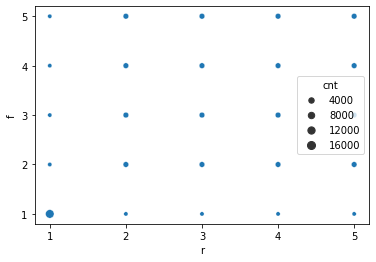

In [57]:
sns.scatterplot(data = cnt, x = 'r', y = 'f', size = 'cnt')

# Iterators

In [58]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [59]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}